# Simplified Image Generator
The model I will create and use in this demonstartion is a simplified image generator which takes inspiration from Generative Adversarial Networks (GAN). However, the goal of this model is not to generate plausible images, but rather to generate images which are similar to the images used to train the model. For this reason, I tried to use a generator without a discriminator, and to adopt a loss function which can substitute the discriminator. By doing so, if we accept not to obtain photorealistic images as output, but rather similar or stylized representations of what we expect as output, we can use a simplified model (without a discriminator) which is then more stable and faster to train.

I will use this model to try to generate images of landscapes.

In [8]:
import numpy as np
import os
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers
import datetime
import matplotlib.pyplot as plt

# Data preparation
The following function takes as input the folder path where training images are stored and the desired image size. This model will be trained on square images, so each image in the folder will be center-cropped, rescaled to the desired size (with equal width and height), converted to a numpy array and its pixel values will be rescaled to values in the range [0, 1].

In [2]:
def load_data(path, imsize):
    imfiles = os.listdir(path)
    ims = []
    for f in imfiles:
        file = os.path.join(path, f)
        with Image.open(file) as im:
            width, height = im.size
            # center crop
            crop_size = min(height, width)
            left = (width - crop_size) / 2
            top = (height - crop_size) / 2
            right = (width + crop_size) / 2
            bottom = (height + crop_size) / 2
            im = im.crop((left, top, right, bottom))

            # resize
            im = im.resize(
                (imsize, imsize),
                resample=Image.Resampling.LANCZOS
            )

            image = np.asarray(im)
            ims.append(image)
    ims = np.array(ims).astype('float32')
    # rescale
    ims /= 255.0
    return ims

# The simplified generator model
## Generator
The simplified generator model is the same as the generator of GAN models. It takes a representation of an image in a latent space of *n* dimensions and produces an image by progressively upsampling an image from its representation in the latent space.

Parameters:
* `latent_dim`: number of dimensions of the latent space representation
* `filters`: minimum number of filters to use in the convolutional layers
* `steps`: number of upsampling steps
* `imsize`: size of the desired image
* `channels`: number of image channels (1 for grayscale, 3 for rgb) (this will have a default value of 3, because I will use only clored, rgb images)

In [3]:
def make_model(latent_dim, filters, steps, imsize, channels=3):
    model = tf.keras.models.Sequential()
    model.add(layers.InputLayer(input_shape=(latent_dim,)))
    side = imsize // 2**steps
    model.add(layers.Dense(filters * 2**steps * side**2, activation='relu'))
    model.add(layers.Reshape((side, side, filters*2**steps)))

    for i in range(steps):
        # model.add(layers.UpSampling2D(
        #     size=2,
        #     interpolation='bilinear'
        # ))
        model.add(layers.Conv2DTranspose(
            filters * 2**(steps-1-i),
            kernel_size=4,
            strides=2,
            padding='same',
            use_bias=False,
            activation='relu'
        ))
        # model.add(layers.BatchNormalization())
    
    model.add(layers.Conv2DTranspose(
        channels,
        kernel_size=3,
        strides=1,
        padding='same',
        use_bias=False,
        activation='sigmoid'
    ))
    return model

## Loss function
The loss function is meant to substitute the discriminator in the training of the generator. It will evaluate the model loss by combining three metrics:
* The structural similarity index [SSIM](https://www.tensorflow.org/api_docs/python/tf/image/ssim)
* The [mean absolute error](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/mean_absolute_error)
* The [binary crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/binary_crossentropy)

In [4]:
def mix_loss(y_true, y_pred):
    # average SSIM of the images bath
    avg_ssim = tf.math.reduce_mean(
        tf.image.ssim(
            y_true,
            y_pred,
            max_val=1.0
        )
    )
    # dissimilarity = 1 - SSIM
    dssim_loss = 1 - avg_ssim
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    bce = tf.keras.metrics.binary_crossentropy(y_true, y_pred)
    return dssim_loss + mae + bce

# Parameters definition

In [5]:
# image parameters
channels = 3
exponent = 7
imsize = 2**exponent
imsize_out = 2**10
# model parameters
sampling_steps= exponent - 3
latent_dim = imsize * 2
filters = channels * 16
# training parameters
epochs = 100
batch_size = 5
new_model = True # False to progress training of previous models
training = True # False to skip training and generate image
loss = mix_loss
# file system
modelname = f'simplegen_{filters}filts_{imsize}px_{latent_dim}latent_{sampling_steps}steps.h5'
picspath = 'data'
modelfile = os.path.join('Models', modelname)

# Model setup

In [6]:
model = make_model(
    latent_dim,
    filters,
    sampling_steps,
    imsize,
    channels=channels
)
if not new_model:
    model.load_weights(modelfile)
model.compile(
    optimizer='adam',
    loss=loss
)

2023-05-16 22:23:39.125568: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-16 22:23:39.170351: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-16 22:23:39.170924: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

# Data loading

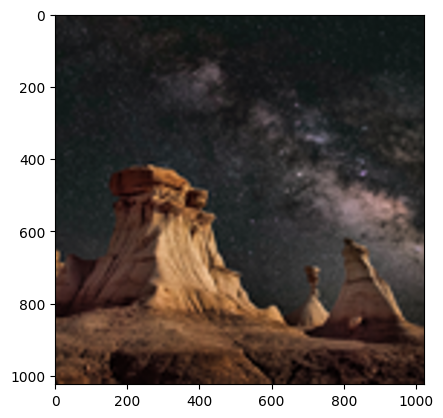

In [11]:
if training:
    y = load_data(picspath, imsize)
    x = tf.random.normal(shape=(y.shape[0], latent_dim), seed=42)
    # the seed is set for reproducibility, and for training the same input on the same images
    
    sample = (255.0 * y[0]).astype('uint8')
    sample = Image.fromarray(sample)
    sample = sample.resize(
        (imsize_out, imsize_out),
        resample=Image.Resampling.BICUBIC
    )

    plt.imshow(sample)
    plt.show()

# Model training and saving

In [9]:
if training:
    model.fit(
        x,
        y,
        epochs=epochs,
        batch_size=batch_size
    )
    model.save_weights(modelfile)

2023-05-16 22:28:29.383107: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 87293952 exceeds 10% of free system memory.
2023-05-16 22:28:29.570153: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 87293952 exceeds 10% of free system memory.


Epoch 1/100


2023-05-16 22:28:31.988846: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-05-16 22:28:33.839164: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x1d50eb10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-16 22:28:33.839216: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce GTX 850M, Compute Capability 5.0
2023-05-16 22:28:34.323586: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-16 22:28:35.390455: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


89/89 [==============================] - 21s 155ms/step - loss: 1.5672
Epoch 2/100
89/89 [==============================] - 13s 144ms/step - loss: 1.5632
Epoch 3/100
89/89 [==============================] - 13s 145ms/step - loss: 1.4874
Epoch 4/100
89/89 [==============================] - 13s 144ms/step - loss: 1.3464
Epoch 5/100
89/89 [==============================] - 13s 144ms/step - loss: 1.2426
Epoch 6/100
89/89 [==============================] - 13s 144ms/step - loss: 1.1902
Epoch 7/100
89/89 [==============================] - 13s 145ms/step - loss: 1.1562
Epoch 8/100
89/89 [==============================] - 13s 144ms/step - loss: 1.1285
Epoch 9/100
89/89 [==============================] - 13s 145ms/step - loss: 1.1031
Epoch 10/100
89/89 [==============================] - 13s 144ms/step - loss: 1.0835
Epoch 11/100
89/89 [==============================] - 13s 145ms/step - loss: 1.0621
Epoch 12/100
89/89 [==============================] - 13s 144ms/step - loss: 1.0422
Epoch 13/100


# Output image generation

1/1 [==============================] - 0s 349ms/step


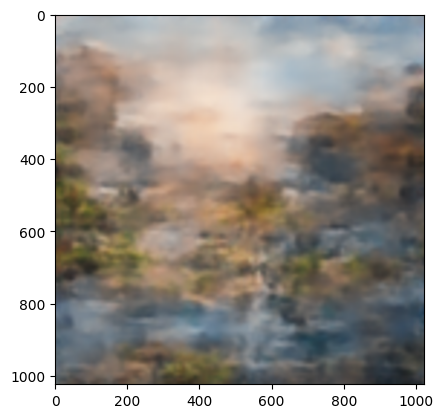

In [10]:
noise = tf.random.normal(shape=(1, latent_dim))
img = model.predict(noise)
img = (255.0 * img[0]).astype('uint8')
img = Image.fromarray(img)
img = img.resize(
    (imsize_out, imsize_out),
    resample=Image.Resampling.BICUBIC
)
fileout = f'output{datetime.datetime.now()}.jpg'
img.save(fileout)

plt.imshow(img)
plt.show()

The image produced is blurry and has some unrealistic artifacts in it. But with its colors and the shapes in it, it still gives somewhat the idea of a landscape.